In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

### Read Data

In [2]:
calendar = pd.read_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\calendar.csv')
sales = pd.read_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\sales_train_validation.csv')
sell_price = pd.read_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\sell_prices.csv')

### Fill in the columns to be predicted
History data : d_1 ~ d_1913

Predict:
- Validation : d_1914 ~ d_1941
- Evaluation : d_1942 ~ d_1969

In [3]:
sales_fill_date = sales.copy()
date_list = []
for i in range(1914, 1970):
    date_list.append('d_'+str(i))
fill_date = pd.DataFrame(columns = date_list)
sales_fill_date = pd.concat([sales_fill_date, fill_date], axis = 1)
print(sales_fill_date)

                                  id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1960  d_1961  d_1962  \
0         CA_1       CA

### Select a group to predict

Demo
- dept_id : HOBBIES_1
- state_id : CA_1

In [5]:
# Group by category & state
sales_g1 = sales_fill_date[(sales_fill_date['dept_id']=='HOBBIES_1')&(sales_fill_date['store_id']=='CA_1')]

# Transform the data
sales_g1_melt = pd.melt(sales_g1, id_vars=sales_g1.columns[:6], value_vars=sales_g1.columns[6:])
sales_g1_melt.columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']

# Merge all dataset
sales_g1_melt_merge = pd.merge(sales_g1_melt, calendar, how = 'left')
sales_g1_melt_merge = pd.merge(sales_g1_melt_merge, sell_price, how = 'left')
sales_g1_melt_merge = sales_g1_melt_merge.sort_values(['id', 'date']).reset_index(drop = True)
print(sales_g1_melt_merge)

                                   id        item_id    dept_id   cat_id  \
0       HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1       HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
2       HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
3       HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
4       HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
...                               ...            ...        ...      ...   
819099  HOBBIES_1_424_CA_1_validation  HOBBIES_1_424  HOBBIES_1  HOBBIES   
819100  HOBBIES_1_424_CA_1_validation  HOBBIES_1_424  HOBBIES_1  HOBBIES   
819101  HOBBIES_1_424_CA_1_validation  HOBBIES_1_424  HOBBIES_1  HOBBIES   
819102  HOBBIES_1_424_CA_1_validation  HOBBIES_1_424  HOBBIES_1  HOBBIES   
819103  HOBBIES_1_424_CA_1_validation  HOBBIES_1_424  HOBBIES_1  HOBBIES   

       store_id state_id       d sales        date  wm_yr_wk  ... month  year  \
0     

### Feature process

In [6]:
# Select useful columns
df = sales_g1_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday',
                          'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']].copy()
# Directly change event to 0 & 1
df['event_name_1'] = (df['event_name_1'].notnull()).astype('int')
df['event_name_2'] = (df['event_name_2'].notnull()).astype('int')
# Extract the last two digits for week info (eg. 11101 -> 01)
df['wm_yr_wk'] = df['wm_yr_wk'].apply(lambda x: int(str(x)[-2:]))

### Split data

In [7]:
# train : d_1 ~ d_1985
train = df.loc[df['d'].isin(list(df['d'].unique()[:-84]))]
# test : d_1986 ~ d_1913
test = df.loc[df['d'].isin(list(df['d'].unique()[-84:-56]))]

# Drop the data with no price info
train = train[train['sell_price'].notna()]

X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
y_train = train['sales'].astype('int')
X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
y_test = test['sales']

### Modeling - LGBM

In [8]:
lgbm = lgb.LGBMRegressor()
# Train model
'''
learning_rate = [0.15, 0.2, 0.25]
max_depth = [15, 20, 25]
param_grid = {'learning_rate': learning_rate, 'max_depth': max_depth}
cv_lgbm = GridSearchCV(lgbm, param_grid, cv=10, n_jobs =1)
cv_lgbm.fit(X_train, y_train)
best_lg = cv_lgbm.best_estimator_
lgbm_pred = best_lg.predict(X_test)
lgbm_pred = np.round(lgbm_pred, 0)
'''
# Default parameter
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_pred = np.round(lgbm_pred, 0)
# Performance
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse(lgbm_pred, y_test)

2.654401020987556

### Plot performance

Benchmark: sum of sales for all items in the group

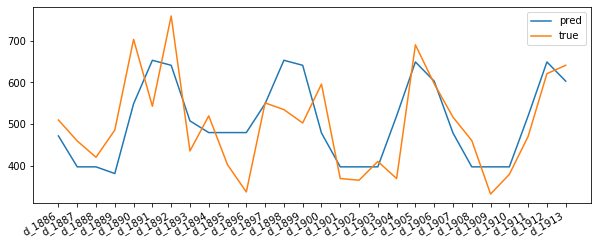

In [10]:
final_pred = pd.concat([test[['d']].reset_index(drop=True), pd.DataFrame(lgbm_pred)], axis=1)
final_pred.columns = ['d', 'pred']
final_pred = pd.concat([final_pred, y_test.reset_index(drop=True)], axis = 1)
final_pred['sales'] = final_pred['sales'].astype('int')
final_pred = final_pred.groupby('d').sum().reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(final_pred['d'], final_pred['pred'], label = 'pred')
ax.plot(final_pred['d'], final_pred['sales'], label = 'true')
ax.legend()
fig.autofmt_xdate()

## Add features & Try different models

- Day weight
- LGBM & XGBoost

In [17]:
df = sales_g1_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday',
                          'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']].copy()
df['event_name_1'] = (df['event_name_1'].notnull()).astype('int')
df['event_name_2'] = (df['event_name_2'].notnull()).astype('int')
# Extract the last two digits for week info
df['wm_yr_wk'] = df['wm_yr_wk'].apply(lambda x: int(str(x)[-2:]))

# Add day influence
group_sales = df[['d', 'sales']].groupby('d').sum()
day_weight = ((group_sales-group_sales.mean())/group_sales.mean()).reset_index()
day_weight.columns = ['d', 'day_weight']
df = pd.merge(df, day_weight, on = 'd', how = 'left')

# train : d_1 ~ d_1985
train = df.loc[df['d'].isin(list(df['d'].unique()[:-84]))]
# test : d_1986 ~ d_1913
test = df.loc[df['d'].isin(list(df['d'].unique()[-84:-56]))]
# Drop the data with no price info
train = train[train['sell_price'].notna()]
X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price', 'day_weight']]
y_train = train['sales'].astype('int')
X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price', 'day_weight']]
y_test = test['sales']

### Modeling - LGBM

In [18]:
lgbm = lgb.LGBMRegressor()
# Default parameter
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_pred = np.round(lgbm_pred, 0)
# Performance
rmse(lgbm_pred, y_test)

2.609056764005375

### Plot performance

Benchmark: sum of sales for all items in the group

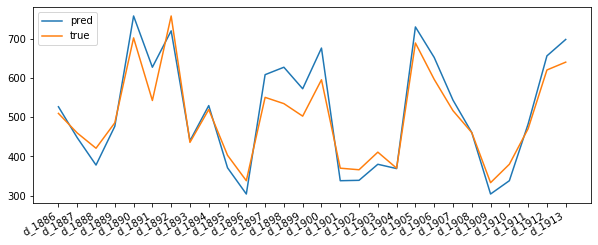

In [19]:
final_pred = pd.concat([test[['d']].reset_index(drop=True), pd.DataFrame(lgbm_pred)], axis=1)
final_pred.columns = ['d', 'pred']
final_pred = pd.concat([final_pred, y_test.reset_index(drop=True)], axis = 1)
final_pred['sales'] = final_pred['sales'].astype('int')
final_pred = final_pred.groupby('d').sum().reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(final_pred['d'], final_pred['pred'], label = 'pred')
ax.plot(final_pred['d'], final_pred['sales'], label = 'true')
ax.legend()
fig.autofmt_xdate()

### Modeling - XGBoost

In [15]:
import xgboost as xgb
# Default parameter
clfpre = xgb.XGBRegressor()
clf = clfpre.fit(X_train, y_train)
xgb_prediction = clf.predict(X_test)
xgb_prediction = np.round(xgb_prediction, 0)
# Performance
rmse(xgb_prediction, y_test)

2.585455674335966

### Plot performance

Benchmark: sum of sales for all items in the group

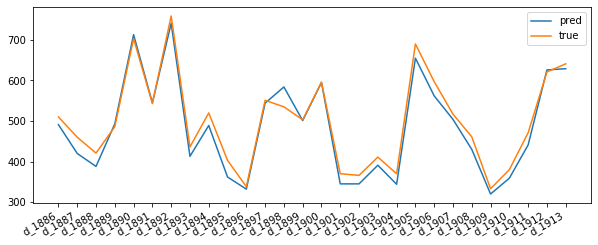

In [16]:
final_pred = pd.concat([test[['d']].reset_index(drop=True), pd.DataFrame(xgb_prediction)], axis=1)
final_pred.columns = ['d', 'pred']
final_pred = pd.concat([final_pred, y_test.reset_index(drop=True)], axis = 1)
final_pred['sales'] = final_pred['sales'].astype('int')
final_pred = final_pred.groupby('d').sum().reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(final_pred['d'], final_pred['pred'], label = 'pred')
ax.plot(final_pred['d'], final_pred['sales'], label = 'true')
ax.legend()
fig.autofmt_xdate()

### Predict all category

Model : LGBM
Parameter : default

In [10]:
final_all = pd.DataFrame()
for cat in sales['cat_id'].unique():
    for state in sales['state_id'].unique():
        sales_group = sales_fill_date[(sales_fill_date['cat_id']==cat)&(sales_fill_date['state_id']==state)]
        sales_group_melt = pd.melt(sales_group, id_vars=sales_group.columns[:6], value_vars=sales_group.columns[6:])
        sales_group_melt.columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales']
        sales_group_melt_merge = pd.merge(sales_group_melt, calendar)
        sales_group_melt_merge = pd.merge(sales_group_melt_merge, sell_price, how = 'left')
        sales_group_melt_merge = sales_group_melt_merge.sort_values(['id', 'date']).reset_index(drop = True)
        if state == 'CA':
            df = sales_group_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                                      'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']].copy()
        elif state == 'TX':
            df = sales_group_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                                      'event_name_1', 'event_name_2', 'snap_TX', 'sell_price']].copy()
        else:
            df = sales_group_melt_merge[['id', 'item_id', 'dept_id', 'store_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
                                         'event_name_1', 'event_name_2', 'snap_WI', 'sell_price']].copy()
        df['event_name_1'] = (df['event_name_1'].notnull()).astype('int')
        df['event_name_2'] = (df['event_name_2'].notnull()).astype('int')
        # Extract the last two digits for week info
        df['wm_yr_wk'] = df['wm_yr_wk'].apply(lambda x: int(str(x)[-2:]))
        
        train = df.loc[df['d'].isin(list(df['d'].unique()[:-56]))]
        test = df.loc[df['d'].isin(list(df['d'].unique()[-56:]))]
        
        train = train[train['sell_price'].notna()]
        if state == 'CA':
            X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
            X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_CA', 'sell_price']]
        elif state == 'TX':
            X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_TX', 'sell_price']]
            X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_TX', 'sell_price']]
        else:
            X_train = train[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_WI', 'sell_price']]
            X_test = test[['wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'snap_WI', 'sell_price']]
        y_train = train['sales'].astype('int')
        y_test = test['sales']

        # Modeling
        lgbm = lgb.LGBMRegressor()
        lgbm.fit(X_train, y_train)
        lgbm_pred = lgbm.predict(X_test)
        lgbm_pred = np.round(lgbm_pred, 0)
        final_pred = pd.concat([test[['id', 'd']].reset_index(drop=True), pd.DataFrame(lgbm_pred)], axis=1)
        final_pred.columns = ['id', 'd', 'values']
        final_pred = final_pred.pivot(index='id', columns='d', values='values').reset_index()
        
        final_all = pd.concat([final_all, final_pred], axis = 0)
        
print(final_all)

d                                id  d_1914  d_1915  d_1916  d_1917  d_1918  \
0     HOBBIES_1_001_CA_1_validation     1.0     1.0     1.0     1.0     1.0   
1     HOBBIES_1_001_CA_2_validation     1.0     1.0     1.0     1.0     1.0   
2     HOBBIES_1_001_CA_3_validation     1.0     1.0     1.0     1.0     1.0   
3     HOBBIES_1_001_CA_4_validation     1.0     1.0     1.0     1.0     1.0   
4     HOBBIES_1_002_CA_1_validation     0.0     0.0     0.0     0.0     0.0   
...                             ...     ...     ...     ...     ...     ...   
4306    FOODS_3_826_WI_2_validation     2.0     2.0     2.0     2.0     2.0   
4307    FOODS_3_826_WI_3_validation     2.0     2.0     2.0     2.0     2.0   
4308    FOODS_3_827_WI_1_validation     4.0     4.0     4.0     4.0     4.0   
4309    FOODS_3_827_WI_2_validation     4.0     4.0     4.0     4.0     4.0   
4310    FOODS_3_827_WI_3_validation     4.0     4.0     4.0     4.0     4.0   

d     d_1919  d_1920  d_1921  d_1922  ...  d_1960  

### Final submission processing

In [11]:
# Validation : d_1914 ~ d_1941
final_val = final_all.iloc[:,:29]
# Evaluation : d_1942 ~ d_1969
final_eval = pd.concat([final_all.iloc[:,0], final_all.iloc[:,29:]], axis = 1)
final_eval['id'] = final_eval['id'].str.replace('validation', 'evaluation')

submission_colnames = ['id']
for i in range(1,29):
    submission_colnames.append('F'+str(i))

final_val.columns = submission_colnames
final_eval.columns = submission_colnames

submission = pd.concat([final_val, final_eval], axis = 0)
#submission.to_csv(r'G:\我的雲端硬碟\UIUC-IS\Kaggle\m5-forecasting-accuracy\submission.csv', index = False)
print(submission)

                                 id   F1   F2   F3   F4   F5   F6   F7   F8  \
0     HOBBIES_1_001_CA_1_validation  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     HOBBIES_1_001_CA_2_validation  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     HOBBIES_1_001_CA_3_validation  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     HOBBIES_1_001_CA_4_validation  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4     HOBBIES_1_002_CA_1_validation  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                             ...  ...  ...  ...  ...  ...  ...  ...  ...   
4306    FOODS_3_826_WI_2_evaluation  2.0  2.0  2.0  2.0  2.0  3.0  3.0  2.0   
4307    FOODS_3_826_WI_3_evaluation  2.0  2.0  2.0  2.0  2.0  3.0  3.0  2.0   
4308    FOODS_3_827_WI_1_evaluation  4.0  4.0  4.0  4.0  4.0  5.0  5.0  3.0   
4309    FOODS_3_827_WI_2_evaluation  4.0  4.0  4.0  4.0  4.0  5.0  5.0  3.0   
4310    FOODS_3_827_WI_3_evaluation  4.0  4.0  4.0  4.0  4.0  5.0  5.0  3.0   

       F9  ...  F19  F20  F21  F22  F23  F24  F25  

### Next step

- feature extract (event)
- model evaluation (tune para, different model)
- time series method